# 第四章 基础实战——FashionMNIST时装分类

<img src="https://github.com/datawhalechina/thorough-pytorch/blob/main/%E7%AC%AC%E5%9B%9B%E7%AB%A0%20PyTorch%E5%9F%BA%E7%A1%80%E5%AE%9E%E6%88%98/fashion-mnist-sprite.png?raw=1" width="400" />  
  
经过前面三章内容的学习，我们完成了以下的内容：  
- 对PyTorch有了初步的认识
- 学会了如何安装PyTorch以及对应的编程环境
- 学习了PyTorch最核心的理论基础（张量&自动求导）
- 梳理了利用PyTorch完成深度学习的主要步骤和对应实现方式  
  
现在，我们通过一个基础实战案例，将第一部分所涉及的PyTorch入门知识串起来，便于大家加深理解。同时为后续的进阶学习打好基础。 
  
我们这里的任务是对10个类别的“时装”图像进行分类，使用FashionMNIST数据集（https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion ）。上图给出了FashionMNIST中数据的若干样例图，其中每个小图对应一个样本。  
FashionMNIST数据集中包含已经预先划分好的训练集和测试集，其中训练集共60,000张图像，测试集共10,000张图像。每张图像均为单通道黑白图像，大小为32\*32pixel，分属10个类别。  
  
下面让我们一起将第三章各部分内容逐步实现，来跑完整个深度学习流程。

**首先导入必要的包**  

In [13]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

**配置训练环境和超参数**  


In [14]:
# 配置GPU，这里有两种方式
## 方案一：使用os.environ
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# 方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## 配置其他超参数，如batch_size, num_workers, learning rate, 以及总的epochs
batch_size = 256
num_workers = 4
lr = 1e-4
epochs = 20

**数据读入和加载**  
这里同时展示两种方式:  
- 下载并使用PyTorch提供的内置数据集  
- 从网站下载以csv格式存储的数据，读入并转成预期的格式    
第一种数据读入方式只适用于常见的数据集，如MNIST，CIFAR10等，PyTorch官方提供了数据下载。这种方式往往适用于快速测试方法（比如测试下某个idea在MNIST数据集上是否有效）  
第二种数据读入方式需要自己构建Dataset，这对于PyTorch应用于自己的工作中十分重要  
  
同时，还需要对数据进行必要的变换，比如说需要将图片统一为一致的大小，以便后续能够输入网络训练；需要将数据格式转为Tensor类，等等。
  
这些变换可以很方便地借助torchvision包来完成，这是PyTorch官方用于图像处理的工具库，上面提到的使用内置数据集的方式也要用到。PyTorch的一大方便之处就在于它是一整套“生态”，有着官方和第三方各个领域的支持。这些内容我们会在后续课程中详细介绍。

In [15]:
# 首先设置数据变换
from torchvision import transforms

image_size = 28
data_transform = transforms.Compose([
    # transforms.ToTensor(),   # 这一步取决于后续的数据读取方式，如果使用内置数据集则不需要
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [16]:
## 读取方式一：使用torchvision自带数据集，下载可能需要一段时间
from torchvision import datasets

train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=data_transform)
test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=data_transform)

在构建训练和测试数据集完成后，需要定义DataLoader类，以便在训练和测试时加载数据  


In [5]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


读入后，我们可以做一些数据可视化操作，主要是验证我们读入的数据是否正确

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 1, 28, 28]) torch.Size([256])


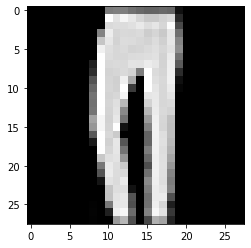

In [17]:
import matplotlib.pyplot as plt
image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[0][0], cmap="gray")

**模型设计**  
由于任务较为简单，这里我们手搭一个CNN，而不考虑当下各种模型的复杂结构  
模型构建完成后，将模型放到GPU上用于训练  


In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

model = Net()
model = model.cuda()
# model = nn.DataParallel(model).cuda()   # 多卡训练时的写法，之后的课程中会进一步讲解

**设定损失函数**  
使用torch.nn模块自带的CrossEntropy损失  
PyTorch会自动把整数型的label转为one-hot型，用于计算CE loss  
这里需要确保label是从0开始的，同时模型不加softmax层（使用logits计算）,这也说明了PyTorch训练中各个部分不是独立的，需要通盘考虑

In [19]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=[1,1,1,1,3,1,1,1,1,1])

In [34]:
?nn.CrossEntropyLoss # 这里方便看一下weighting等策略

**设定优化器**  
这里我们使用Adam优化器  

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

**训练和测试（验证）**  
各自封装成函数，方便后续调用  
关注两者的主要区别：  
- 模型状态设置  
- 是否需要初始化优化器
- 是否需要将loss传回到网络
- 是否需要每步更新optimizer  
  
此外，对于测试或验证过程，可以计算分类准确率

In [21]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        data, label = data.cuda(), label.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [22]:
def val(epoch):       
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(test_loader.dataset)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [23]:
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1 	Training Loss: 0.652788
Epoch: 1 	Validation Loss: 0.454471, Accuracy: 0.835700
Epoch: 2 	Training Loss: 0.411024
Epoch: 2 	Validation Loss: 0.372158, Accuracy: 0.869900
Epoch: 3 	Training Loss: 0.355220
Epoch: 3 	Validation Loss: 0.333022, Accuracy: 0.879600
Epoch: 4 	Training Loss: 0.323823
Epoch: 4 	Validation Loss: 0.298990, Accuracy: 0.892100
Epoch: 5 	Training Loss: 0.303856
Epoch: 5 	Validation Loss: 0.288878, Accuracy: 0.896900
Epoch: 6 	Training Loss: 0.284870
Epoch: 6 	Validation Loss: 0.278586, Accuracy: 0.898000
Epoch: 7 	Training Loss: 0.270739
Epoch: 7 	Validation Loss: 0.262508, Accuracy: 0.904700
Epoch: 8 	Training Loss: 0.257120
Epoch: 8 	Validation Loss: 0.259808, Accuracy: 0.903100
Epoch: 9 	Training Loss: 0.249207
Epoch: 9 	Validation Loss: 0.252463, Accuracy: 0.910000
Epoch: 10 	Training Loss: 0.238911
Epoch: 10 	Validation Loss: 0.253971, Accuracy: 0.910100
Epoch: 11 	Training Loss: 0.230471
Epoch: 11 	Validation Loss: 0.252551, Accuracy: 0.908100
Epoch:

**模型保存**  
训练完成后，可以使用torch.save保存模型参数或者整个模型，也可以在训练过程中保存模型  
这部分会在后面的课程中详细介绍

In [24]:
save_path = "./FahionModel.pkl"
torch.save(model, save_path)